In [1]:
%matplotlib inline
from fastai import *
from fastai.vision import *

In [2]:
sz = 128

path = Path('data')
path_img = path/f'train-{sz}'

In [3]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('data/train-128/car_103163.png'),
 PosixPath('data/train-128/passport_81943.png'),
 PosixPath('data/train-128/scorpion_33063.png'),
 PosixPath('data/train-128/swing_set_23016.png'),
 PosixPath('data/train-128/skyscraper_52499.png')]

In [4]:
pat = r'/([^/]+)_\d+.png$'

In [5]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=128, test=Path('../test-128'))
data.normalize(imagenet_stats)

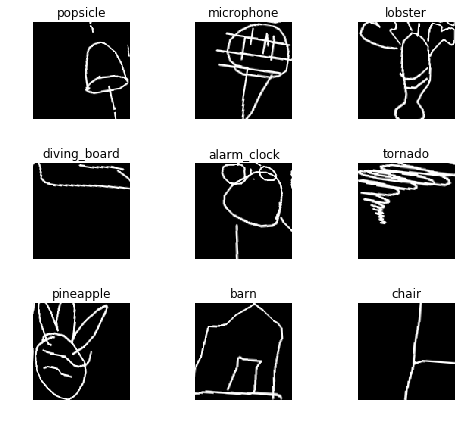

In [6]:
data.show_batch(rows=3, figsize=(7,6))

In [7]:
print(data.classes)
len(data.classes),data.c

['car', 'passport', 'scorpion', 'swing_set', 'skyscraper', 'animal_migration', 'broom', 'floor_lamp', 'knee', 'steak', 'fire_hydrant', 'crab', 'camel', 'ant', 'barn', 'cannon', 'beard', 'bench', 'stitches', 'grapes', 'paintbrush', 'sock', 'fireplace', 'potato', 'waterslide', 'horse', 'pickup_truck', 'bird', 'dog', 'keyboard', 'panda', 'marker', 'radio', 'computer', 'frog', 'whale', 'hat', 'snowman', 'palm_tree', 'mouse', 'belt', 'sleeping_bag', 'peas', 'lightning', 'hockey_puck', 'camera', 'hourglass', 'vase', 'picture_frame', 'eraser', 'hand', 'violin', 'sea_turtle', 'windmill', 'jacket', 'snorkel', 'megaphone', 'frying_pan', 'pants', 'flashlight', 'leg', 'face', 'paint_can', 'parrot', 'washing_machine', 'moon', 'hamburger', 'mailbox', 'boomerang', 'mouth', 'pizza', 'bush', 'clarinet', 'string_bean', 'finger', 'raccoon', 'elephant', 'stethoscope', 'tennis_racquet', 'peanut', 'The_Great_Wall_of_China', 'parachute', 'squirrel', 'backpack', 'flamingo', 'sun', 'map', 'crayon', 'book', 'sh

(340, 340)

In [9]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [11]:
learn.fit_one_cycle(4)

Total time: 43:29
epoch  train_loss  valid_loss  error_rate
1      1.529565    1.110463    0.311039    (10:51)
2      1.551907    1.092447    0.303884    (10:53)
3      1.348240    0.987103    0.277081    (10:51)
4      1.369227    0.952487    0.268120    (10:53)



In [12]:
learn.save('quick-draw-stage-1')

# Results

In [13]:
interp = ClassificationInterpretation.from_learner(learn)

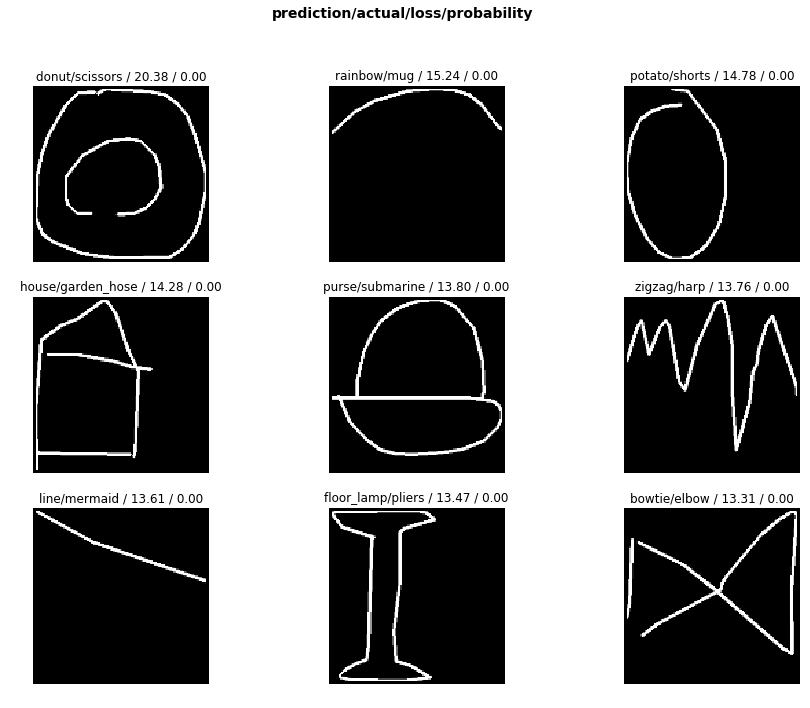

In [14]:
interp.plot_top_losses(9, figsize=(15,11))

# Unfreezing, fine-tuning, and learning rates¶

In [16]:
learn.load('quick-draw-stage-1')

In [17]:
learn.unfreeze()

In [18]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


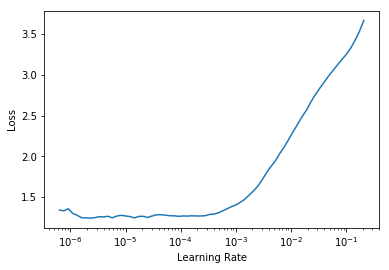

In [19]:
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(2, max_lr=slice(5e-6,5e-4))

Total time: 31:33
epoch  train_loss  valid_loss  error_rate
1      1.198613    0.911115    0.258497    (15:45)
2      1.079182    0.809188    0.231965    (15:47)



In [21]:
learn.save('quick-draw-stage-2')

# Generate submission

In [22]:
learn.load('quick-draw-stage-2')

In [23]:
preds = learn.TTA(is_test=True)[0]

Total time: 11:33



In [24]:
top_3 = np.argsort(preds.numpy())[:, ::-1][:, :3]

In [25]:
n, _ = top_3.shape
labels = []
for i in range(n):
    labels.append(' '.join([learn.data.train_ds.ds.classes[idx] for idx in top_3[i]]))

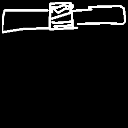

In [26]:
learn.data.test_dl.dl.dataset[0][0]

In [27]:
labels[0]

'belt square dishwasher'

In [28]:
key_ids = [path.stem for path in learn.data.test_dl.dl.dataset.x]

In [29]:
os.makedirs(f'subs', exist_ok=True)

In [30]:
sub = pd.DataFrame({'key_id': key_ids, 'word': labels})

In [31]:
sub.head()

,key_id,word
0,9083303642204918,belt square dishwasher
1,9299690584699015,paintbrush wristwatch microphone
2,9318243600848667,paint_can drums cup
3,9778177565835737,eraser cooler barn
4,9927431669040616,harp jail grass


In [32]:
name = 'first_sub'

In [33]:
sub.to_csv(f'subs/{name}.csv.gz', index=False, compression='gzip')

In [34]:
pd.read_csv(f'subs/{name}.csv.gz').head()

,key_id,word
0,9083303642204918,belt square dishwasher
1,9299690584699015,paintbrush wristwatch microphone
2,9318243600848667,paint_can drums cup
3,9778177565835737,eraser cooler barn
4,9927431669040616,harp jail grass


In [35]:
!kaggle competitions submit -c quickdraw-doodle-recognition -f subs/{name}.csv.gz -m "{name}"

100%|██████████████████████████████████████| 1.58M/1.58M [00:00<00:00, 1.84MB/s]
Successfully submitted to Quick, Draw! Doodle Recognition Challenge